In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 605ms/step - loss: 6.3747e-05
Average validation loss: 0.9471794962882996
4/4 [==============================] - 6s 624ms/step - loss: 6.3747e-05 - val_loss: 0.9472
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 604ms/step - loss: 6.4653e-05 - val_loss: 0.9472
Average validation loss: 0.6127207279205322
4/4 [==============================] - 8s 621ms/step - loss: 6.4653e-05 - val_loss: 0.7800
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 595ms/step - loss: 6.2862e-05 - val_loss: 0.7800
Average validation loss: 0.5923941135406494
4/4 [==============================] - 11s 611ms/step - loss: 6.2862e-05 - val_loss: 0.7174
Saved model weigh

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 736ms/step - loss: 1.4046e-04
Average validation loss: 2.2222143411636353
8/8 [==============================] - 6s 761ms/step - loss: 1.4046e-04 - val_loss: 2.2222
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 722ms/step - loss: 1.4117e-04 - val_loss: 2.2222
Average validation loss: 0.1213991716504097
8/8 [==============================] - 12s 739ms/step - loss: 1.4117e-04 - val_loss: 1.1718
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 726ms/step - loss: 1.4247e-04 - val_loss: 1.1718
Average validation loss: 0.05098188854753971
8/8 [==============================] - 18s 739ms/step - loss: 1.4247e-04 - val_loss: 0.7982
Saved model 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 747ms/step - loss: 1.3351e-04
Average validation loss: 0.6716143687566122
12/12 [==============================] - 9s 760ms/step - loss: 1.3351e-04 - val_loss: 0.6716
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 706ms/step - loss: 1.2961e-04 - val_loss: 0.6716
Average validation loss: 0.1453652655084928
12/12 [==============================] - 18s 716ms/step - loss: 1.2961e-04 - val_loss: 0.4085
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 27s 734ms/step - loss: 1.2654e-04 - val_loss: 0.4085
Average validation loss: 0.5245086153348287
12/12 [==============================] - 27s 748ms/step - loss: 1.2654e-04 - val_loss: 0.4472
E

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 727ms/step - loss: 1.3231e-04
Average validation loss: 0.16243006847798824
16/16 [==============================] - 12s 740ms/step - loss: 1.3231e-04 - val_loss: 0.1624
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 717ms/step - loss: 1.2212e-04 - val_loss: 0.1624
Average validation loss: 0.4004953168332577
16/16 [==============================] - 24s 731ms/step - loss: 1.2212e-04 - val_loss: 0.2815
Epoch 3/10
16/16 [==============================] - 35s 718ms/step - loss: 1.1795e-04 - val_loss: 0.2815
Average validation loss: 0.22927759028971195
16/16 [==============================] - 35s 732ms/step - loss: 1.1795e-04 - val_loss: 0.2641
Epoch 4/10
16/16 [==============================] - 47s 738ms/step - loss: 1.1502e-04 - val_loss: 0.2641
Average validation loss: 0.933370441198349


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 720ms/step - loss: 1.1493e-04
Average validation loss: 0.3527017652988434
20/20 [==============================] - 15s 731ms/step - loss: 1.1493e-04 - val_loss: 0.3527
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 737ms/step - loss: 1.1087e-04 - val_loss: 0.3527
Average validation loss: 0.11878360211849212
20/20 [==============================] - 30s 749ms/step - loss: 1.1087e-04 - val_loss: 0.2357
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 720ms/step - loss: 1.1016e-04 - val_loss: 0.2357
Average validation loss: 0.46609918773174286
20/20 [==============================] - 45s 733ms/step - loss: 1.1016e-04 - val_loss: 0.31

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 718ms/step - loss: 7.8444e-05
Average validation loss: 1.8774720629056294
24/24 [==============================] - 18s 730ms/step - loss: 7.8444e-05 - val_loss: 1.8775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 720ms/step - loss: 7.8917e-05 - val_loss: 1.8775
Average validation loss: 0.2648025800784429
24/24 [==============================] - 35s 731ms/step - loss: 7.8917e-05 - val_loss: 1.0711
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 720ms/step - loss: 7.9236e-05 - val_loss: 1.0711
Average validation loss: 0.8635006745656332
24/24 [==============================] - 53s 732ms/step - loss: 7.9236e-05 - val_loss: 1.0019

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 721ms/step - loss: 6.8780e-05
Average validation loss: 1.480671215057373
40/40 [==============================] - 29s 733ms/step - loss: 6.8780e-05 - val_loss: 1.4807
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 720ms/step - loss: 6.7050e-05 - val_loss: 1.4807
Average validation loss: 0.9446895241737365
40/40 [==============================] - 59s 732ms/step - loss: 6.7050e-05 - val_loss: 1.2127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 720ms/step - loss: 6.8878e-05 - val_loss: 1.2127
Average validation loss: 0.9203540354967117
40/40 [==============================] - 88s 732ms/step - loss: 6.8878e-05 - val_loss: 1.1152


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 731ms/step - loss: 6.4665e-05
Average validation loss: 1.3667483925819397
48/48 [==============================] - 36s 744ms/step - loss: 6.4665e-05 - val_loss: 1.3667
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 720ms/step - loss: 6.2097e-05 - val_loss: 1.3667
Average validation loss: 2.4983273645242057
48/48 [==============================] - 71s 733ms/step - loss: 6.2097e-05 - val_loss: 1.9325
Epoch 3/10
48/48 [==============================] - 106s 719ms/step - loss: 6.0190e-05 - val_loss: 1.9325
Average validation loss: 1.5908366441726685
48/48 [==============================] - 106s 732ms/step - loss: 6.0190e-05 - val_loss: 1.8186
Epoch 4/10
48/48 [==============================] - 141s 720ms/step - loss: 5.8146e-05 - val_loss: 1.8186
Average validation loss: 1.109086602926254

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 736ms/step - loss: 5.2240e-05
Average validation loss: 0.8352467572050435
56/56 [==============================] - 42s 749ms/step - loss: 5.2240e-05 - val_loss: 0.8352
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 83s 728ms/step - loss: 4.9827e-05 - val_loss: 0.8352
Average validation loss: 1.179307018007551
56/56 [==============================] - 83s 741ms/step - loss: 4.9827e-05 - val_loss: 1.0073
Epoch 3/10
56/56 [==============================] - 125s 739ms/step - loss: 5.0125e-05 - val_loss: 1.0073
Average validation loss: 0.9951763919421605
56/56 [==============================] - 126s 752ms/step - loss: 5.0125e-05 - val_loss: 1.0032
Epoch 4/10
56/56 [==============================] - 166s 727ms/step - loss: 4.9780e-05 - val_loss: 1.0032
Average validation loss: 1.691455999655383


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 730ms/step - loss: 4.6428e-05
Average validation loss: 1.311911627650261
64/64 [==============================] - 48s 742ms/step - loss: 4.6428e-05 - val_loss: 1.3119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 95s 743ms/step - loss: 4.6013e-05 - val_loss: 1.3119
Average validation loss: 1.2153596486896276
64/64 [==============================] - 96s 755ms/step - loss: 4.6013e-05 - val_loss: 1.2636
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 143s 735ms/step - loss: 4.7299e-05 - val_loss: 1.2636
Average validation loss: 1.5411738455295563
64/64 [==============================] - 144s 748ms/step - loss: 4.7299e-05 - val_loss: 1.356

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 722ms/step - loss: 3.8223e-05
Average validation loss: 1.1308055056465998
72/72 [==============================] - 53s 735ms/step - loss: 3.8223e-05 - val_loss: 1.1308
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 106s 730ms/step - loss: 3.6353e-05 - val_loss: 1.1308
Average validation loss: 1.2681979801919725
72/72 [==============================] - 106s 742ms/step - loss: 3.6353e-05 - val_loss: 1.1995
Epoch 3/10
72/72 [==============================] - 159s 725ms/step - loss: 3.5713e-05 - val_loss: 1.1995
Average validation loss: 1.1161962416436937
72/72 [==============================] - 160s 736ms/step - loss: 3.5713e-05 - val_loss: 1.1717
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_90.p

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 726ms/step - loss: 3.7402e-05
Average validation loss: 1.0283699601888656
80/80 [==============================] - 59s 739ms/step - loss: 3.7402e-05 - val_loss: 1.0284
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 724ms/step - loss: 3.5703e-05 - val_loss: 1.0284
Average validation loss: 0.9166641980409622
80/80 [==============================] - 118s 737ms/step - loss: 3.5703e-05 - val_loss: 0.9725
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 176s 720ms/step - loss: 3.4236e-05 - val_loss: 0.9725
Average validation loss: 1.4379922777414322
80/80 [==============================] - 177s 732ms/step - loss: 3.4236e-05 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 720ms/step - loss: 4.0228e-05
Average validation loss: 1.312363011141618
96/96 [==============================] - 70s 731ms/step - loss: 4.0228e-05 - val_loss: 1.3124
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 722ms/step - loss: 3.6398e-05 - val_loss: 1.3124
Average validation loss: 1.2822702787816525
96/96 [==============================] - 141s 735ms/step - loss: 3.6398e-05 - val_loss: 1.2973
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 211s 727ms/step - loss: 3.5393e-05 - val_loss: 1.2973
Average validation loss: 1.6194442911073565
96/96 [==============================] - 212s 739ms/step - loss: 3.5393e-05 - val_loss: 1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 720ms/step - loss: 4.6806e-05
Average validation loss: 1.3925286908944448
120/120 [==============================] - 88s 733ms/step - loss: 4.6806e-05 - val_loss: 1.3925
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 724ms/step - loss: 4.4266e-05 - val_loss: 1.3925
Average validation loss: 1.5433627367019653
120/120 [==============================] - 176s 736ms/step - loss: 4.4266e-05 - val_loss: 1.4679
Epoch 3/10
120/120 [==============================] - 263s 722ms/step - loss: 4.2795e-05 - val_loss: 1.4679
Average validation loss: 1.2945779760678608
120/120 [==============================] - 264s 734ms/step - loss: 4.2795e-05 - val_loss: 1.4102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_d

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 5.3849e-05
Average validation loss: 1.2293428877989452
144/144 [==============================] - 106s 733ms/step - loss: 5.3849e-05 - val_loss: 1.2293
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 720ms/step - loss: 5.1086e-05 - val_loss: 1.2293
Average validation loss: 1.5461752116680145
144/144 [==============================] - 211s 733ms/step - loss: 5.1086e-05 - val_loss: 1.3878
Epoch 3/10
144/144 [==============================] - 316s 725ms/step - loss: 4.9572e-05 - val_loss: 1.3878
Average validation loss: 1.5498557372225656
144/144 [==============================] - 317s 738ms/step - loss: 4.9572e-05 - val_loss: 1.4418
Epoch 4/10
144/144 [==============================] - 421s 723ms/step - loss: 4.8112e-05 - val_loss: 1.4418
Average validation loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 116s 725ms/step - loss: 4.4135e-05
Average validation loss: 1.1990942023694515
160/160 [==============================] - 118s 737ms/step - loss: 4.4135e-05 - val_loss: 1.1991
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 234s 726ms/step - loss: 4.1867e-05 - val_loss: 1.1991
Average validation loss: 1.2601000554859638
160/160 [==============================] - 236s 738ms/step - loss: 4.1867e-05 - val_loss: 1.2296
Epoch 3/10
160/160 [==============================] - 352s 724ms/step - loss: 4.1564e-05 - val_loss: 1.2296
Average validation loss: 1.1408039182424545
160/160 [==============================] - 354s 737ms/step - loss: 4.1564e-05 - val_loss: 1.2000
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 145s 726ms/step - loss: 4.7433e-05
Average validation loss: 1.486471107006073
200/200 [==============================] - 148s 739ms/step - loss: 4.7433e-05 - val_loss: 1.4865
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 292s 719ms/step - loss: 4.4832e-05 - val_loss: 1.4865
Average validation loss: 1.493000420331955
200/200 [==============================] - 294s 732ms/step - loss: 4.4832e-05 - val_loss: 1.4897
Epoch 3/10
200/200 [==============================] - 438s 721ms/step - loss: 4.2978e-05 - val_loss: 1.4897
Average validation loss: 1.4556611752510071
200/200 [==============================] - 441s 733ms/step - loss: 4.2978e-05 - val_loss: 1.4784
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_d

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:50 - loss: 1.2149e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 721ms/step - loss: 4.8845e-05
Average validation loss: 1.078959051767985
240/240 [==============================] - 176s 733ms/step - loss: 4.8845e-05 - val_loss: 1.0790
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 720ms/step - loss: 4.4936e-05 - val_loss: 1.0790
Average validation loss: 1.1960506603121757
240/240 [==============================] - 352s 732ms/step - loss: 4.4936e-05 - val_loss: 1.1375
Epoch 3/10
240/240 [==============================] - 525s 724ms/step - loss: 4.2960e-05 - val_loss: 1.1375
Average validation loss: 1.334043216953675
240/240 [==============================] - 528s 737ms/step - loss: 4.2960e-05 - val_loss: 1.2030
Epoch 4/10
240/240 [==============================] - 702s 725ms/step - loss: 4.0561e-05 - val_loss: 1.2030
Average validation loss: 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.7254458121052448, 0.5240922975129797, 0.45073336009805637, 0.8867690306028817, 0.7890153796225786, 0.9218185923993587, 1.2230348624289036, 1.3236878700306018, 1.330215751997062, 1.233625360969454, 1.1609761087472241, 1.2043655679207295, 1.3658274476975203, 1.4023325406908989, 1.375327587351203, 1.4333402810022233, 1.3954105045616627, 1.3301649339670936]
std_val_losses =  [0.527149630458775, 0.590012346394547, 0.3473001850744572, 0.8356824803226449, 0.42777137076966404, 0.34795336114433323, 0.42532671887595536, 0.3161147316119207, 0.20259908696655565, 0.2309353694472195, 0.17639083107522907, 0.22035263574837005, 0.170563010627699, 0.1733896922965457, 0.16364443078254481, 0.15603620896363912, 0.14745750813664693, 0.154363906775875]


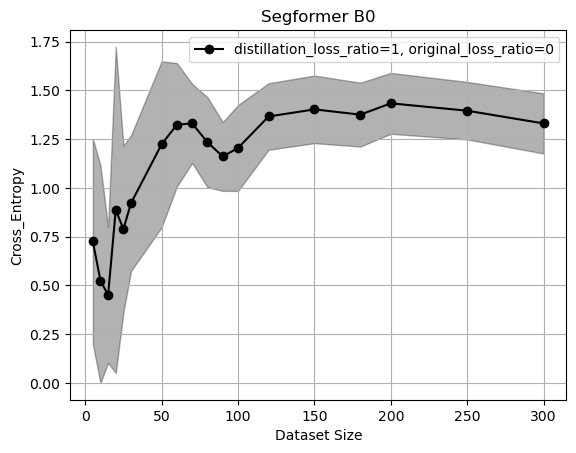

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()